In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import yaml
import os

seed=456

In [68]:
##  Extracting data
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

model_path = config["model"]["path"]
output_path = config["output"]["path"]

train_df = pd.read_csv(config["data"]["processed_train_path"])
test_df = pd.read_csv(config["data"]["processed_test_path"])

# Define our features (X) and target (y)
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
X_train = train_df[features]
X_test=test_df[features]
y_train = train_df['player_won']
#print(features)

X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train,train_size=0.8,shuffle=True, random_state=seed)

In [69]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_vali=scaler.transform(X_vali)
X_test = scaler.transform(X_test)

## Logistic Regression

In [70]:
## GRID SEARCH
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Scaling all the data


model = LogisticRegression(random_state=seed)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 
         ## comment if u change the dataset
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [10000]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_logreg = grid_search.best_estimator_
best_param_lr = grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best model mean validation accuracy: 0.8276
 Standard deviation across validation folds: 0.0115
Best hyperparameters found: {'C': 0.1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy in CV: 0.8276


In [71]:
## TRAINING IN THE TRAINING SET
logreg=LogisticRegression(**best_param_lr,random_state=seed)
logreg.fit(X_train,y_train)
y_pred= logreg.predict(X_vali)
print("acc",accuracy_score(y_vali,y_pred))
best_logreg=logreg

acc 0.8225


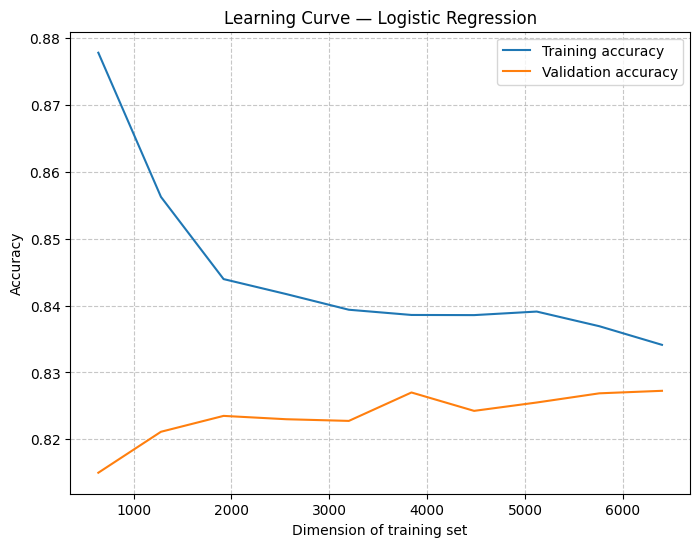

In [48]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    logreg, X_train, y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=seed,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.plot(train_sizes, val_mean, label='Validation accuracy')
plt.xlabel('Dimension of training set')
plt.ylabel('Accuracy')
plt.title('Learning Curve — Logistic Regression')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## KNN

C:\Users\Edoardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Edoardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Edoardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backen

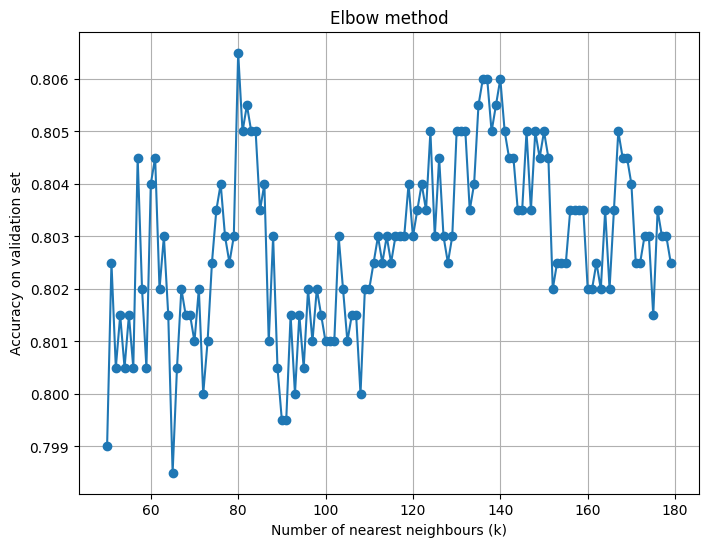

Best k: 80
Accuracy for validation set: 0.8065
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best model mean validation accuracy: 0.8110
 Standard deviation across validation folds: 0.0062
Best hyperparameters found: {'metric': 'minkowski', 'n_neighbors': 80, 'weights': 'distance'}
Best accuracy in CV: 0.8110


In [49]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score



model = KNeighborsClassifier()

k_values = list(range(50,180))
accuracies=[]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_vali)
    acc = accuracy_score(y_vali, y_pred)
    accuracies.append(acc)


plt.figure(figsize=(8,6))
plt.plot(k_values, accuracies, marker='o')
plt.title("Elbow method")
plt.xlabel("Number of nearest neighbours (k)")
plt.ylabel("Accuracy on validation set")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
print(f"Best k: {best_k}")
print(f"Accuracy for validation set: {max(accuracies):.4f}")

param_grid = {
    'n_neighbors': [best_k],           
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski','manhattan', 'euclidean'],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3,
    return_train_score= True
)


grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_knn = grid_search.best_estimator_
best_param_knn = grid_search.best_params_

In [50]:
### This is the total knn classifier

best_knn = KNeighborsClassifier(**best_param_knn)
best_knn.fit(X_train, y_train)
y_pred= best_knn.predict(X_vali)
print("acc",accuracy_score(y_vali,y_pred))

acc 0.8055


# DECISION TREES


In [51]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score


# No need to scale the data

model = DecisionTreeClassifier(random_state=seed)

k_range = list(range(60,200,20))

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'], # impurity function to minimize
    'max_depth': [15], # max_depth of the tree
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_dt = grid_search.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
 Best model mean validation accuracy: 0.7501
 Standard deviation across validation folds: 0.0135
Best hyperparameters found: {'criterion': 'gini', 'max_depth': 15}
Best accuracy in CV: 0.7501


# RANDOM FOREST

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
# Random Forest
rforest = RandomForestClassifier(
    criterion='gini',
    max_depth=10,
    n_estimators=400,
    random_state=seed
)

# K-Fold cross-validation (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Calcolo dell’accuracy media con cross-validation
scores = cross_val_score(rforest, X_train, y_train, cv=kfold, scoring='accuracy')

print("Accuracy per fold:", np.round(scores, 3))
print(f"Accuracy in mean +- stddev: {scores.mean():.3f} ± {scores.std():.3f}")


Accuracy per fold: [0.834 0.816 0.823 0.803 0.819]
Accuracy in mean +- stddev: 0.819 ± 0.010


In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [400, 500, 600],
    'max_depth': [30, 40],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'max_features': ['sqrt'],
    'criterion': ['entropy']
}

# Initialize the base model
rforest = RandomForestClassifier(random_state=seed)

# Set up K-Fold cross-validation (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Set up the Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=rforest,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1,       # use all available CPU cores
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Results
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")

best_param_rf = grid_search.best_params_


Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best model mean validation accuracy: 0.8183
 Standard deviation across validation folds: 0.0092
Best hyperparameters found: {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
Best accuracy in CV: 0.8199


In [54]:
best_rf = RandomForestClassifier(**best_param_rf, random_state=seed)
best_rf.fit(X_train, y_train)
y_pred= best_rf.predict(X_vali)
print("acc",accuracy_score(y_vali,y_pred))

acc 0.8085


# XGBOOST


In [72]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV
import numpy as np
import xgboost as xgb

# Base XGBoost model
xgb = XGBClassifier(
    random_state=seed,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [500, 600],
    'max_depth': [4,5],
    'learning_rate': [0.04, 0.03],
    'gamma': [0],
    'subsample': [0.8],
    'colsample_bytree': [0.9]
}

# K-Fold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Results
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")
# Retrieve the best model
best_xgb = grid_search.best_estimator_

best_param_xgb = grid_search.best_params_


Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Edoardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:199: UserWarning: [00:16:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best model mean validation accuracy: 0.8349
 Standard deviation across validation folds: 0.0092
Best hyperparameters found: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.8}
Best accuracy in CV: 0.8349


[0]	validation_0-logloss:0.68090	validation_1-logloss:0.68176
[1]	validation_0-logloss:0.66963	validation_1-logloss:0.67131
[2]	validation_0-logloss:0.65897	validation_1-logloss:0.66132
[3]	validation_0-logloss:0.64870	validation_1-logloss:0.65164
[4]	validation_0-logloss:0.63911	validation_1-logloss:0.64250
[5]	validation_0-logloss:0.63037	validation_1-logloss:0.63452
[6]	validation_0-logloss:0.62158	validation_1-logloss:0.62645
[7]	validation_0-logloss:0.61316	validation_1-logloss:0.61867
[8]	validation_0-logloss:0.60521	validation_1-logloss:0.61132
[9]	validation_0-logloss:0.59761	validation_1-logloss:0.60406
[10]	validation_0-logloss:0.59080	validation_1-logloss:0.59789
[11]	validation_0-logloss:0.58382	validation_1-logloss:0.59137
[12]	validation_0-logloss:0.57717	validation_1-logloss:0.58541
[13]	validation_0-logloss:0.57107	validation_1-logloss:0.57969
[14]	validation_0-logloss:0.56498	validation_1-logloss:0.57429
[15]	validation_0-logloss:0.55912	validation_1-logloss:0.56878
[1

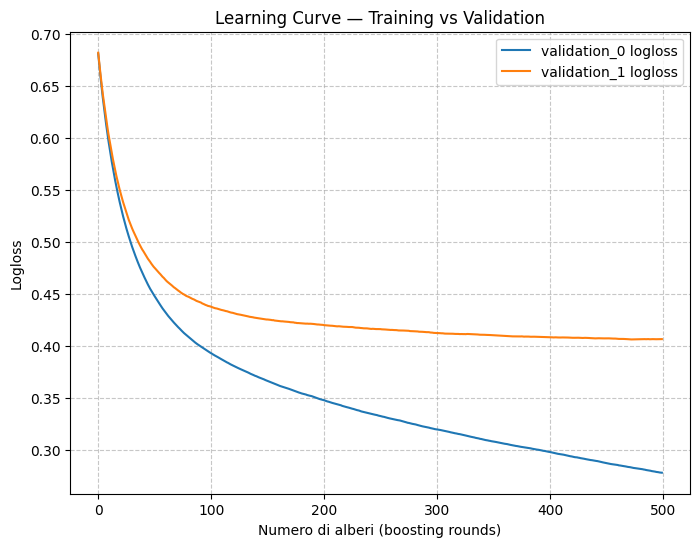

In [73]:
evals_result = {}
best_xgb = XGBClassifier(**best_param_xgb, random_state=seed)
best_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_vali, y_vali)])
y_pred= best_xgb.predict(X_vali)
print("acc",accuracy_score(y_vali,y_pred))

evals_result = best_xgb.evals_result()
print("Chiavi disponibili in evals_result:", evals_result.keys())

# 3️⃣ Recupera le curve in modo dinamico
keys = list(evals_result.keys())
train_key, vali_key = keys[0], keys[1]

train_loss = evals_result[train_key]['logloss']
vali_loss = evals_result[vali_key]['logloss']

# Plot loss
plt.figure(figsize=(8,6))
plt.plot(train_loss, label=f'{train_key} logloss')
plt.plot(vali_loss, label=f'{vali_key} logloss')
plt.xlabel('Numero di alberi (boosting rounds)')
plt.ylabel('Logloss')
plt.title('Learning Curve — Training vs Validation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Playing with feature importance

🔝 Top 10 most important features:
              Feature  Importance
95  health_difference  108.476349
58       p1_fnt_count   31.150862
51     p2_total_moves   26.559134
50     p1_total_moves   20.200943
56       p1_slp_count   18.060297
66       p1_frz_count   16.593960
55  p2_status_changes   15.404584
57       p2_slp_count   15.108263
67       p2_frz_count   14.535530
54  p1_status_changes   13.006125

🔻 Least important 10 features:
                      Feature  Importance
75           p2_reflect_count    4.911553
29              p1_type_water    4.853774
23              p1_type_ghost    4.732272
81  p2_same_type_moves_number    4.534070
35      p2_lead_type_electric    4.528101
36        p2_lead_type_flying    4.350089
41        p2_lead_type_notype    4.012709
22             p1_type_flying    3.494719
39           p2_lead_type_ice    2.914307
62               p1_psn_count    0.972966


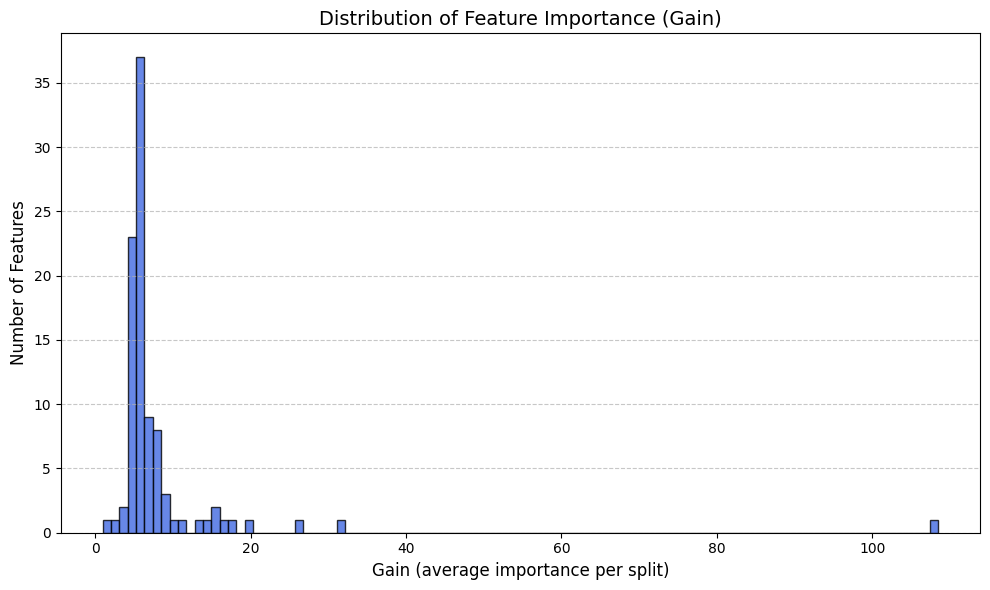

In [74]:
# Extract the trained booster from the best XGBoost model
booster = best_xgb.get_booster()

# Compute feature importance using 'gain' (average contribution to model decisions)
importance = booster.get_score(importance_type='gain')

temp_features = []
for k in importance.keys():
    a = k.strip("f")
    temp_features.append(features[int(a)])


# Convert to DataFrame and sort by importance
importance_df = (
    pd.DataFrame({'Feature': temp_features, 'Importance': list(importance.values())})
    .sort_values(by='Importance', ascending=False)
)

# Display the top and bottom 10 most important features
print("🔝 Top 10 most important features:")
print(importance_df.head(10))

print("\n🔻 Least important 10 features:")
print(importance_df.tail(10))

# Plot the distribution of feature importance values
plt.figure(figsize=(10, 6))
plt.hist(importance_df['Importance'], bins=100, color='royalblue', edgecolor='black', alpha=0.8)
plt.title('Distribution of Feature Importance (Gain)', fontsize=14)
plt.xlabel('Gain (average importance per split)', fontsize=12)
plt.ylabel('Number of Features', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Get the ordered list of feature names by importance
feature_names = importance_df['Feature'].tolist()


In [58]:
# Create placeholder column names
X_train = pd.DataFrame(X_train, columns=[f"f{i}" for i in range(X_train.shape[1])])
X_vali = pd.DataFrame(X_vali, columns=[f"f{i}" for i in range(X_vali.shape[1])])
X_test = pd.DataFrame(X_test, columns=[f"f{i}" for i in range(X_test.shape[1])])
# Check consistency of dimensions
if X_vali.shape[0] != len(y_vali):
    raise ValueError(f"⚠️ Dimension mismatch: X_vali={X_vali.shape[0]}, y_vali={len(y_vali)}")

# Compute the 20th percentile of feature gain and identify the weakest features
p = importance_df['Importance'].quantile(0.05)
worst_feats = importance_df[importance_df['Importance'] < p]['Feature'].tolist()

print(f"Removing {len(worst_feats)} features with gain below the 20th percentile ({p:.4f})")

# Drop the weakest features from both train and validation sets
X_train_reduced = X_train.drop(columns=worst_feats, errors='ignore')
X_vali_reduced = X_vali.drop(columns=worst_feats, errors='ignore')
X_test_reduced = X_test.drop(columns=worst_feats, errors='ignore')
print(f"Original shape: {X_train.shape}")
print(f"Reduced shape:  {X_train_reduced.shape}")

# Retrain a new model using the reduced feature set
xgb_new = XGBClassifier(**best_param_xgb, random_state=seed)
xgb_new.fit(X_train_reduced, y_train)

# Compare accuracy before and after feature selection
acc_before = best_xgb.score(X_vali, y_vali)
acc_after = xgb_new.score(X_vali_reduced, y_vali)


print(f"\n🎯 Original accuracy: {acc_before:.4f}")
print(f"🧹 Accuracy after feature selection (20th percentile): {acc_after:.4f}")

# (Optional) Display the 10 least important features removed
print("\n🔻 10 features with the lowest gain:")
print(importance_df.sort_values(by='Importance', ascending=True).head(10))


Removing 5 features with gain below the 20th percentile (3.9078)
Original shape: (8000, 113)
Reduced shape:  (8000, 113)

🎯 Original accuracy: 0.8280
🧹 Accuracy after feature selection (20th percentile): 0.8280

🔻 10 features with the lowest gain:
                  Feature  Importance
78          p1_wrap_count    2.699541
37    p2_lead_type_flying    3.364608
40       p2_lead_type_ice    3.511474
39     p2_lead_type_grass    3.765407
22       p1_type_electric    3.817939
33            p2_lead_atk    3.907752
77    p2_substitute_count    4.048586
34            p2_lead_def    4.160403
36  p2_lead_type_electric    4.301574
5        p1_mean_base_def    4.308180


In [59]:
####### let's try if it works for rf and logreg
best_rf = RandomForestClassifier(**best_param_rf, random_state=seed)
best_rf.fit(X_train, y_train)
new_rf = RandomForestClassifier(**best_param_rf, random_state=seed)
new_rf.fit(X_train_reduced, y_train)
y_pred= best_rf.predict(X_vali)
print("Random Forest")
print("first acc",accuracy_score(y_vali,y_pred))
y_pred2 = new_rf.predict(X_vali_reduced)
print("second acc",accuracy_score(y_vali,y_pred2))

new_lr = LogisticRegression(**best_param_lr,random_state=seed)
new_lr.fit(X_train_reduced, y_train)
y_pred= best_logreg.predict(X_vali)
print("Logistic regression")
print("first acc",accuracy_score(y_vali,y_pred))
y_pred2 = new_lr.predict(X_vali_reduced)
print("second acc",accuracy_score(y_vali,y_pred2))

Random Forest
first acc 0.8085
second acc 0.8085
Logistic regression
first acc 0.823
second acc 0.823


C:\Users\Edoardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [75]:
seeds = [123, 456, 789]
xgb_models = []

for s in seeds:
    model = XGBClassifier(**best_param_xgb, random_state=s)
    xgb.fit(X_train, y_train)
    xgb_models.append(model)

print(f"✅ Allenati {len(xgb_models)} modelli XGBoost con seed diversi.")
estimators = [
    ('1', xgb_models[0]),
    ('2', xgb_models[1]),
    ('logreg', best_logreg),
    ('3', xgb_models[2])
]

# Meta-learner (impara a combinare i modelli)
meta_model = LogisticRegression(random_state=seed, max_iter=10000)

# Stacking ensemble
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True  # include anche le feature originali
)

stack.fit(X_train, y_train)
print("Stacking accuracy:", stack.score(X_vali, y_vali))
best_stck=stack

C:\Users\Edoardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:199: UserWarning: [00:17:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Allenati 3 modelli XGBoost con seed diversi.
Stacking accuracy: 0.831


# ENSEMBLE

In [61]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('logreg', best_logreg),
        ('knn', best_knn)
    ],
    voting='soft'  # or 'hard' if models don’t support predict_proba
)

ensemble.fit(X_train, y_train)

print("Ensemble accuracy:", ensemble.score(X_vali, y_vali))

Ensemble accuracy: 0.826


In [62]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Base learners
estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('logreg', best_logreg),
    ('knn', best_knn)
]

# Meta-learner (impara a combinare i modelli)
meta_model = LogisticRegression(random_state=seed, max_iter=10000)

# Stacking ensemble
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True  # include anche le feature originali
)

stack.fit(X_train, y_train)
print("Stacking accuracy:", stack.score(X_vali, y_vali))

Stacking accuracy: 0.83


In [63]:
print(X_test)

            f0        f1        f2        f3        f4        f5        f6  \
0     1.203652  1.608280  0.409184 -0.142053 -0.574743 -0.576135 -0.769057   
1     0.454888 -0.466753  0.409184  0.092901 -0.574743  0.018813  0.462983   
2    -2.477771 -0.466753 -3.242728  1.737579  1.462224  1.548679  0.110972   
3     0.829270  0.570764  0.409184  1.150194  1.462224  0.528768  0.110972   
4    -1.541816  0.570764 -1.857520  2.090010  1.462224  1.038723  0.110972   
...        ...       ...       ...       ...       ...       ...       ...   
4995 -2.103389 -1.504269 -1.857520  2.090010 -0.574743  2.993552  2.223040   
4996  0.267697 -0.466753  0.409184 -1.316823 -0.574743 -1.596045 -0.769057   
4997 -0.780572 -0.466753  0.409184  0.069405  1.869618  0.103806  0.462983   
4998  0.642079  0.570764  0.409184  0.210378 -0.574743 -0.066179 -0.769057   
4999 -0.917846 -1.504269  0.409184 -0.259530  1.462224  1.633671  2.223040   

            f7        f8        f9  ...      f103      f104    

In [64]:
best_model=best_stck
#best_model=best_xgb

# SUBMISSIONS


In [65]:
# Testing the prediction on the test set

print("Generating predictions on the test set...")
test_predictions = best_model.predict(X_test)

Generating predictions on the test set...


In [66]:

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    'player_won': test_predictions
})
# Save the DataFrame to a .csv file
submission_df.to_csv(output_path, index=False)

print("\n'submission.csv' file created successfully!")


'submission.csv' file created successfully!
